In [1]:
import os ,yaml
from operator import itemgetter
from tools.import_data import *
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [2]:
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import feature_selection as fs
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Imputer # for NaN values

In [8]:
def train_the_data(X_train,Y_train,models):
    # Spot Check Algorithms with cross validation
    # evaluate each model in turn
    scores = []
    names = []
    results = []
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10)
        try:
            cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold,n_jobs=-1, scoring=SCORING )
        except ValueError as e:
            print('ValueError{}'.format(None))
        else:
            scores.append(cv_results)
            names.append(name)
            results.append({"name":name,"score":cv_results.mean()})
            # msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
            # print(msg)
    # Compare Algorithms
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(scores)
    ax.set_xticklabels(names)
    plt.show()
    return results
        
def test_the_data(X_train,Y_train,X_test,Y_test,models):
    # Make predictions on test dataset
    results = []
    for name, model in models:
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        # print('Model ' , name)
        # print('Accuracy: ', accuracy_score(Y_test, predictions))
        results.append({"name":name,"score":accuracy_score(Y_test, predictions)})
        #print(confusion_matrix(Y_validation, predictions))
        # print(classification_report(Y_test, predictions))
    return results 
    # 
    # encoder(predict_dataset)
    # #print (predict_dataset)
    # predict=predict_dataset.values[:,0:22]
    # 
    # predictions = lr.predict(predict)
    
    # temp = pandas.DataFrame(predict)
    # temp['class'] = predictions
    # temp.to_csv('predict.csv')
def get_the_best(results): # input - list of dict {"name":name,"score":score}
    m = max([k["score"] for k in results])
    i = [k["score"] for k in results].index(m)
    name = results[i]["name"]
    printmd('The best model for the given data is: <span style="color:green">' + str(name).format() + '</span> with the score <span style="color:green">' + str(m) + '</span>' )
    # print ('The best model for the given train (' + X_train.shape +') is: ' + name + 'with the score ' +m )
    return results[i] # the max model (dict type)

# def information_gain(X, y):
#     def _entropy(labels):
#         counts = np.bincount(labels)
#         return entropy(counts, base=None)
# 
#     def _ig(x, y):
#         # indices where x is set/not set
#         x_set = np.nonzero(x)[1]
#         x_not_set = np.delete(np.arange(x.shape[1]), x_set)
# 
#         h_x_set = _entropy(y[x_set])
#         h_x_not_set = _entropy(y[x_not_set])
# 
#         return entropy_full - (((len(x_set) / f_size) * h_x_set)
#                              + ((len(x_not_set) / f_size) * h_x_not_set))
# 
#     entropy_full = _entropy(y)
# 
#     f_size = float(X.shape[0])
# 
#     scores = np.array([_ig(x, y) for x in X.T])
#     return scores

In [9]:
#consts
FILE_PATH = os.path.dirname(os.path.abspath("__file__"))
CONFIG_FILE = os.path.join(FILE_PATH,'config.yml')
config = yaml.load(open(CONFIG_FILE,'r'))
TRAIN_FILE = config['files']['train_set']
TEST_FILE = config['files']['test_set']
SCORING = config['score']

models = []
    
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

if __name__ == "__main__":
    X_train, Y_train , original_headers_train = load_dataset(TRAIN_FILE) 
    print ('Train data shape: ', X_train.shape)
    print ('Train labels shape: ', Y_train.shape)
    if TEST_FILE:
        X_test, Y_test ,original_headers_test = load_dataset(TEST_FILE)
        print ('Test data shape: ', X_test.shape)
        print ('Test labels shape: ', Y_test.shape)

Train data shape:  (776, 21)
Train labels shape:  (776,)


In [5]:
    # Encoding Categorial features and imputing NaN's
    # https://chrisalbon.com/machine_learning/preprocessing_structured_data/convert_pandas_categorical_column_into_integers_for_scikit-learn/
    # http://pbpython.com/categorical-encoding.html
    # https://datascience.stackexchange.com/questions/14069/mass-convert-categorical-columns-in-pandas-not-one-hot-encoding
    char_cols = X_train.dtypes.pipe(lambda x: x[x == 'object']).index
    if not char_cols.empty:
        label_mapping = {}
        for c in char_cols:
            X_train_non_numeric = X_train.copy()
            X_train[c], label_mapping[c] = pd.factorize(X_train[c])
    imp = Imputer(axis=0, verbose=1)
    imp = imp.fit(X_train)
    X_train_imp = imp.transform(X_train)
    print ('New Train data shape: ',X_train_imp.shape)
    fs_scores = fs.mutual_info_classif(X_train_imp,Y_train)
    feature_scores_list = []
    for i,score in enumerate(fs_scores):
        feature_scores_list.append({'feature_name':original_headers_train[i],'score':score})
    feature_scores_list.sort(key=itemgetter('score'),reverse=True)
    for feature in feature_scores_list:
        print (feature)

New Train data shape:  (776, 21)


{'feature_name': 'SYM_YRS_SINCE_HEARTBURN_START', 'score': 0.15831363668354803}
{'feature_name': 'SYM_YRS_SINCE_ACID_TASTE_START', 'score': 0.14614762763071476}
{'feature_name': 'SEX', 'score': 0.087282279923559081}
{'feature_name': 'SYM_CHEST_PAIN', 'score': 0.079128326560164775}
{'feature_name': 'SYM_TAKING_STOMACH_MEDS', 'score': 0.077986074008813411}
{'feature_name': 'WAIST_CIRCUMFERENCE', 'score': 0.073971615306134941}
{'feature_name': 'SYM_BURNING_CHEST', 'score': 0.064817252969855632}
{'feature_name': 'AGE', 'score': 0.0576068306695392}
{'feature_name': 'HEIGHT', 'score': 0.052711922875013251}
{'feature_name': 'WEIGHT', 'score': 0.049837888278378761}
{'feature_name': 'SYM_ACID_TASTE', 'score': 0.036543331737880491}
{'feature_name': 'SYM_SLEEP_DISRUPTED', 'score': 0.0347961565485011}
{'feature_name': 'ALC_UNITS_PER_WEEK', 'score': 0.03208134988739797}
{'feature_name': 'SMK_EVER_SMOKED', 'score': 0.027582189716119476}
{'feature_name': 'ALC_UNITS_PER_WEEK_AGED_30', 'score': 0.02487

In [17]:
    #before we found the elbow
    new_trains = []
    # new_shapes_ratio = []
    # new_range = []
    myrange = np.arange(0.01, 1, 0.01)
    for VTHRESH in myrange:  
        # sel = fs.VarianceThreshold(VTHRESH)
        sel = fs.SelectPercentile(score_func=fs.mutual_info_classif,percentile=VTHRESH*100)
        # sel.fit(X_train_imp,Y_train)
        # print (sel.get_params())
        # print (sel.get_support())
        X_train_mod = sel.fit_transform(X_train_imp,Y_train)
        if len(new_trains) >= 1:
            if new_trains[-1]['ratio']!= X_train_mod.shape[-1]/X_train.shape[-1]:
                # new_range.append(VTHRESH)
                # new_trains.append(X_train_mod)
                # new_shapes_ratio.append(X_train_mod.shape[-1]/X_train.shape[-1])
                mask = sel.get_support() #list of booleans
                new_features = [] # The list of your K best features    
                for bool, feature in zip(mask, original_headers_train):
                    if bool:
                        new_features.append(feature)
                new_trains.append({'threshold':VTHRESH,
                                   'X_train':X_train_mod,
                                   'ratio':X_train_mod.shape[-1]/X_train.shape[-1],
                                   'features_name':new_features})
                
        else:
            # new_range.append(VTHRESH)
            # new_trains.append(X_train_mod)
            # new_shapes_ratio.append(X_train_mod.shape[-1]/X_train.shape[-1])
            mask = sel.get_support() #list of booleans
            new_features = [] # The list of your K best features    
            for bool, feature in zip(mask, original_headers_train):
                if bool:
                    new_features.append(feature)
            new_trains.append({'threshold':VTHRESH,
                               'X_train':X_train_mod,
                               'ratio':X_train_mod.shape[-1]/X_train.shape[-1],
                               'features_name':new_features})

**Training Section** for: 1 features (['SYM_YRS_SINCE_HEARTBURN_START'])

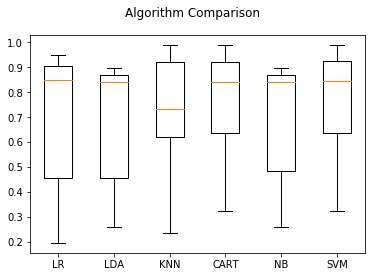

The best model for the given data is: <span style="color:green">SVM</span> with the score <span style="color:green">0.757925407925</span>

{'name': 'LR', 'score': 0.69695304695304694}
{'name': 'LDA', 'score': 0.68934398934398933}
{'name': 'KNN', 'score': 0.70767565767565777}
{'name': 'CART', 'score': 0.75406260406260417}
{'name': 'NB', 'score': 0.69843489843489848}
{'name': 'SVM', 'score': 0.75792540792540797}


**Training Section** for: 2 features (['SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START'])

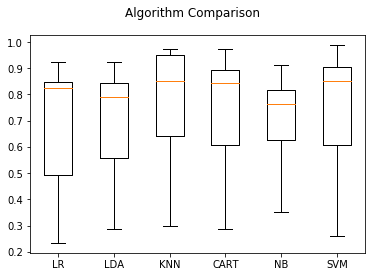

The best model for the given data is: <span style="color:green">KNN</span> with the score <span style="color:green">0.764219114219</span>

{'name': 'LR', 'score': 0.69335664335664338}
{'name': 'LDA', 'score': 0.70258075258075259}
{'name': 'KNN', 'score': 0.76421911421911415}
{'name': 'CART', 'score': 0.7475191475191475}
{'name': 'NB', 'score': 0.70281385281385289}
{'name': 'SVM', 'score': 0.7475191475191475}


**Training Section** for: 3 features (['SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

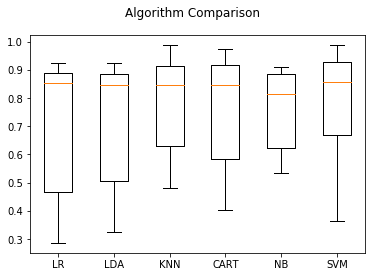

The best model for the given data is: <span style="color:green">KNN</span> with the score <span style="color:green">0.777522477522</span>

{'name': 'LR', 'score': 0.71010656010656015}
{'name': 'LDA', 'score': 0.72049617049617054}
{'name': 'KNN', 'score': 0.77752247752247738}
{'name': 'CART', 'score': 0.75922410922410921}
{'name': 'NB', 'score': 0.76225441225441215}
{'name': 'SVM', 'score': 0.77216117216117208}


**Training Section** for: 4 features (['SEX', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

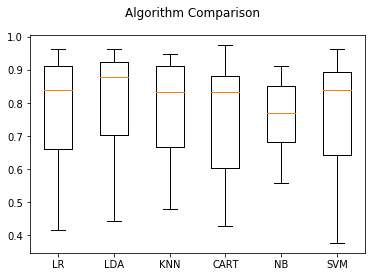

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.795604395604</span>

{'name': 'LR', 'score': 0.76595071595071595}
{'name': 'LDA', 'score': 0.79560439560439566}
{'name': 'KNN', 'score': 0.7814352314352313}
{'name': 'CART', 'score': 0.75168165168165157}
{'name': 'NB', 'score': 0.76122211122211125}
{'name': 'SVM', 'score': 0.75422910422910427}


**Training Section** for: 5 features (['SEX', 'SYM_CHEST_PAIN', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

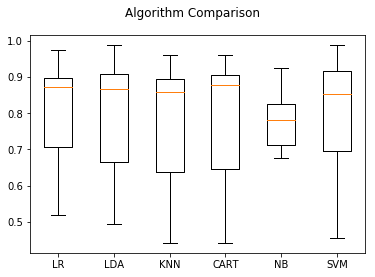

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.800849150849</span>

{'name': 'LR', 'score': 0.80084915084915076}
{'name': 'LDA', 'score': 0.79823509823509819}
{'name': 'KNN', 'score': 0.77619047619047632}
{'name': 'CART', 'score': 0.7709956709956709}
{'name': 'NB', 'score': 0.78075258075258069}
{'name': 'SVM', 'score': 0.78396603396603393}


**Training Section** for: 6 features (['SEX', 'WAIST_CIRCUMFERENCE', 'SYM_BURNING_CHEST', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

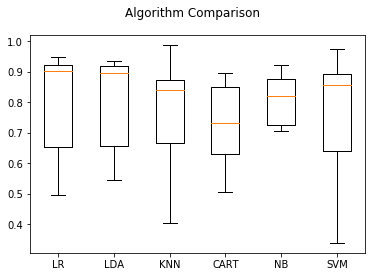

The best model for the given data is: <span style="color:green">NB</span> with the score <span style="color:green">0.806543456543</span>

{'name': 'LR', 'score': 0.80341325341325331}
{'name': 'LDA', 'score': 0.80472860472860464}
{'name': 'KNN', 'score': 0.76067266067266059}
{'name': 'CART', 'score': 0.72492507492507496}
{'name': 'NB', 'score': 0.80654345654345649}
{'name': 'SVM', 'score': 0.74890109890109902}


**Training Section** for: 7 features (['SEX', 'HEIGHT', 'WAIST_CIRCUMFERENCE', 'SYM_CHEST_PAIN', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

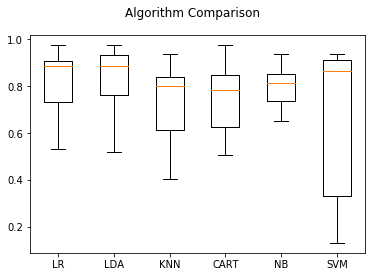

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.824042624043</span>

{'name': 'LR', 'score': 0.81505161505161505}
{'name': 'LDA', 'score': 0.82404262404262396}
{'name': 'KNN', 'score': 0.72584082584082588}
{'name': 'CART', 'score': 0.74170829170829167}
{'name': 'NB', 'score': 0.80526140526140522}
{'name': 'SVM', 'score': 0.66568431568431574}


**Training Section** for: 8 features (['SEX', 'WAIST_CIRCUMFERENCE', 'ALC_UNITS_PER_WEEK_AGED_30', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

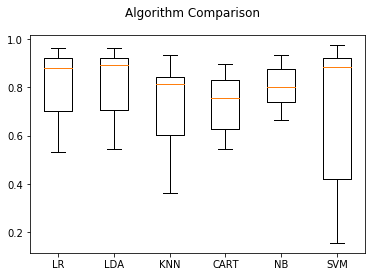

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.82022977023</span>

{'name': 'LR', 'score': 0.8150849150849151}
{'name': 'LDA', 'score': 0.82022977022977028}
{'name': 'KNN', 'score': 0.72970362970362967}
{'name': 'CART', 'score': 0.73531468531468513}
{'name': 'NB', 'score': 0.8040626040626041}
{'name': 'SVM', 'score': 0.70449550449550447}


**Training Section** for: 9 features (['SEX', 'HEIGHT', 'WAIST_CIRCUMFERENCE', 'SMK_AGE_SMOKING_STOPPED', 'SYM_CHEST_PAIN', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

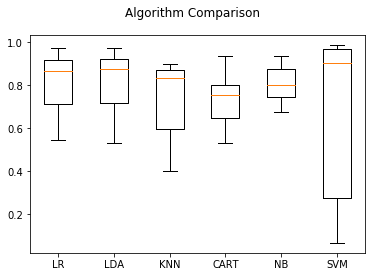

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.816333666334</span>

{'name': 'LR', 'score': 0.81120546120546122}
{'name': 'LDA', 'score': 0.81633366633366644}
{'name': 'KNN', 'score': 0.73220113220113225}
{'name': 'CART', 'score': 0.74297369297369298}
{'name': 'NB', 'score': 0.80531135531135534}
{'name': 'SVM', 'score': 0.67440892440892442}


**Training Section** for: 10 features (['SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'ALC_UNITS_PER_WEEK_AGED_30', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

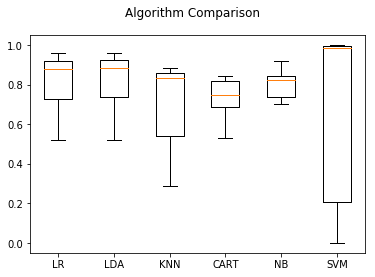

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.82022977023</span>

{'name': 'LR', 'score': 0.81376956376956378}
{'name': 'LDA', 'score': 0.82022977022977028}
{'name': 'KNN', 'score': 0.69721944721944729}
{'name': 'CART', 'score': 0.73151848151848153}
{'name': 'NB', 'score': 0.80281385281385287}
{'name': 'SVM', 'score': 0.67797202797202805}


**Training Section** for: 11 features (['SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'SMK_AGE_SMOKING_STOPPED', 'PREFERRED_DRINK', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

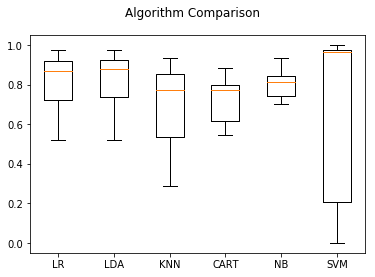

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.82022977023</span>

{'name': 'LR', 'score': 0.8124875124875125}
{'name': 'LDA', 'score': 0.82022977022977028}
{'name': 'KNN', 'score': 0.69342324342324335}
{'name': 'CART', 'score': 0.72753912753912753}
{'name': 'NB', 'score': 0.80402930402930406}
{'name': 'SVM', 'score': 0.6689976689976691}


**Training Section** for: 12 features (['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'SMK_EVER_SMOKED', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

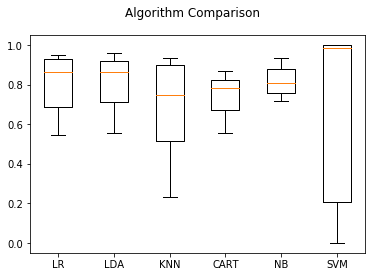

The best model for the given data is: <span style="color:green">NB</span> with the score <span style="color:green">0.816916416916</span>

{'name': 'LR', 'score': 0.80857475857475847}
{'name': 'LDA', 'score': 0.81510156510156517}
{'name': 'KNN', 'score': 0.68682983682983678}
{'name': 'CART', 'score': 0.7482683982683983}
{'name': 'NB', 'score': 0.81691641691641692}
{'name': 'SVM', 'score': 0.67795537795537797}


**Training Section** for: 13 features (['AGE', 'SEX', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'EDUCATION_LEVEL', 'SMK_AGE_SMOKING_STOPPED', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_ACID_TASTE', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

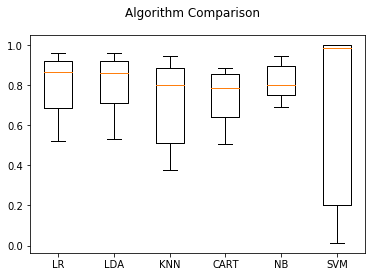

The best model for the given data is: <span style="color:green">NB</span> with the score <span style="color:green">0.819480519481</span>

{'name': 'LR', 'score': 0.80214785214785223}
{'name': 'LDA', 'score': 0.81122211122211119}
{'name': 'KNN', 'score': 0.71403596403596403}
{'name': 'CART', 'score': 0.74034299034299034}
{'name': 'NB', 'score': 0.81948051948051948}
{'name': 'SVM', 'score': 0.67925407925407932}


**Training Section** for: 14 features (['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'SMK_AGE_SMOKING_STOPPED', 'ALC_UNITS_PER_WEEK_AGED_30', 'ALC_DRINK_HEAVILY', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

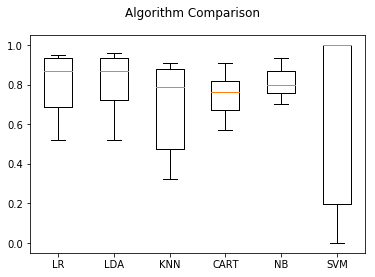

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.817649017649</span>

{'name': 'LR', 'score': 0.81245421245421245}
{'name': 'LDA', 'score': 0.81764901764901765}
{'name': 'KNN', 'score': 0.69204129204129206}
{'name': 'CART', 'score': 0.7546786546786548}
{'name': 'NB', 'score': 0.81182151182151185}
{'name': 'SVM', 'score': 0.67792207792207793}


**Training Section** for: 15 features (['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'SMK_EVER_SMOKED', 'SMK_AGE_STARTED', 'SMK_AGE_SMOKING_STOPPED', 'ALC_UNITS_PER_WEEK_AGED_30', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

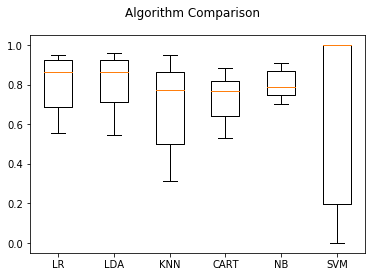

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.812520812521</span>

{'name': 'LR', 'score': 0.80990675990675987}
{'name': 'LDA', 'score': 0.81252081252081254}
{'name': 'KNN', 'score': 0.69079254079254082}
{'name': 'CART', 'score': 0.73519813519813515}
{'name': 'NB', 'score': 0.80144855144855143}
{'name': 'SVM', 'score': 0.67792207792207793}


**Training Section** for: 16 features (['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'EDUCATION_LEVEL', 'SMK_AGE_SMOKING_STOPPED', 'ALC_UNITS_PER_WEEK_AGED_30', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_ACID_TASTE', 'SYM_SORE_THROAT', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

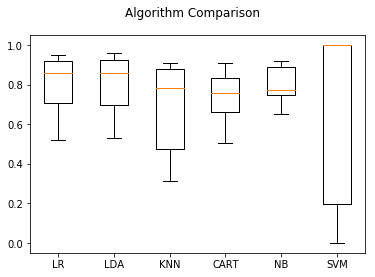

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.808658008658</span>

{'name': 'LR', 'score': 0.79958374958374956}
{'name': 'LDA', 'score': 0.80865800865800863}
{'name': 'KNN', 'score': 0.69074259074259081}
{'name': 'CART', 'score': 0.74430569430569427}
{'name': 'NB', 'score': 0.80149850149850155}
{'name': 'SVM', 'score': 0.67792207792207793}


**Training Section** for: 17 features (['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'EDUCATION_LEVEL', 'SMK_EVER_SMOKED', 'SMK_AGE_SMOKING_STOPPED', 'ALC_UNITS_PER_WEEK_AGED_30', 'ALC_DRINK_HEAVILY', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_ACID_TASTE', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

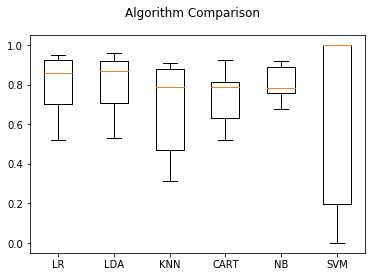

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.809923409923</span>

{'name': 'LR', 'score': 0.80344655344655336}
{'name': 'LDA', 'score': 0.80992340992340994}
{'name': 'KNN', 'score': 0.68944388944388946}
{'name': 'CART', 'score': 0.74297369297369298}
{'name': 'NB', 'score': 0.80922410922410926}
{'name': 'SVM', 'score': 0.67792207792207793}


**Training Section** for: 18 features (['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'EDUCATION_LEVEL', 'SMK_EVER_SMOKED', 'SMK_AGE_STARTED', 'SMK_AGE_SMOKING_STOPPED', 'ALC_UNITS_PER_WEEK', 'ALC_UNITS_PER_WEEK_AGED_30', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_ACID_TASTE', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

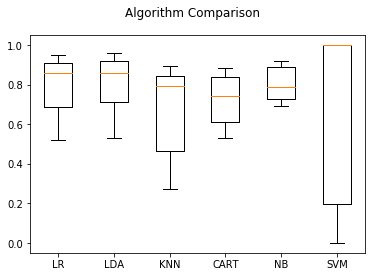

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.806060606061</span>

{'name': 'LR', 'score': 0.79830169830169839}
{'name': 'LDA', 'score': 0.80606060606060626}
{'name': 'KNN', 'score': 0.67787212787212781}
{'name': 'CART', 'score': 0.72614052614052615}
{'name': 'NB', 'score': 0.80139860139860131}
{'name': 'SVM', 'score': 0.67792207792207793}


**Training Section** for: 19 features (['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'EDUCATION_LEVEL', 'SMK_EVER_SMOKED', 'SMK_AGE_STARTED', 'SMK_AGE_SMOKING_STOPPED', 'ALC_UNITS_PER_WEEK_AGED_30', 'ALC_DRINK_HEAVILY', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_ACID_TASTE', 'SYM_SORE_THROAT', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

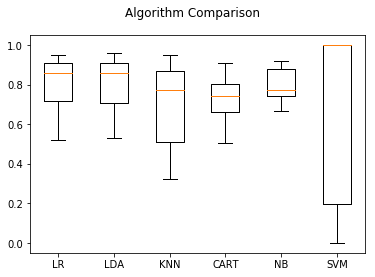

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.807392607393</span>

{'name': 'LR', 'score': 0.79960039960039953}
{'name': 'LDA', 'score': 0.80739260739260743}
{'name': 'KNN', 'score': 0.69595404595404597}
{'name': 'CART', 'score': 0.72878787878787876}
{'name': 'NB', 'score': 0.79890109890109895}
{'name': 'SVM', 'score': 0.67792207792207793}


**Training Section** for: 20 features (['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'EDUCATION_LEVEL', 'SMK_EVER_SMOKED', 'SMK_AGE_STARTED', 'SMK_AGE_SMOKING_STOPPED', 'ALC_UNITS_PER_WEEK', 'ALC_UNITS_PER_WEEK_AGED_30', 'ALC_DRINK_HEAVILY', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_ACID_TASTE', 'SYM_SORE_THROAT', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

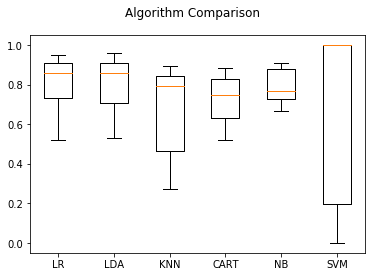

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.807392607393</span>

{'name': 'LR', 'score': 0.80218115218115216}
{'name': 'LDA', 'score': 0.80739260739260743}
{'name': 'KNN', 'score': 0.67657342657342656}
{'name': 'CART', 'score': 0.72742257742257743}
{'name': 'NB', 'score': 0.79372294372294372}
{'name': 'SVM', 'score': 0.67792207792207793}


In [18]:
    best_tr_results = []
    # new_trains.reverse()
    for train_set in new_trains:
        X_train_mod = train_set['X_train']
        printmd("**Training Section** for: {} features ({})".format(str(X_train_mod.shape[-1]),train_set['features_name']))
        train_resultes = train_the_data(X_train_mod,Y_train,models)
        if train_resultes:
            best_tr = get_the_best(train_resultes)
            best_tr_results.append({"name":best_tr['name'],
                                    "score":best_tr['score'],
                                    "num_fetures":int(X_train_mod.shape[-1]),
                                    'features_names':train_set['features_name']})
            for model in train_resultes:
                print (model)

In [31]:
    for best in best_tr_results:
        print(best)
    plt.plot([d['threshold'] for d in new_trains],
             [d['ratio'] for d in new_trains],
             [rs['score'] for rs in best_tr_results])

{'name': 'SVM', 'score': 0.75792540792540797, 'num_fetures': 1, 'features_names': ['SYM_YRS_SINCE_HEARTBURN_START']}
{'name': 'KNN', 'score': 0.76421911421911415, 'num_fetures': 2, 'features_names': ['SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START']}
{'name': 'KNN', 'score': 0.77752247752247738, 'num_fetures': 3, 'features_names': ['SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS']}
{'name': 'LDA', 'score': 0.79560439560439566, 'num_fetures': 4, 'features_names': ['SEX', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS']}
{'name': 'LR', 'score': 0.80084915084915076, 'num_fetures': 5, 'features_names': ['SEX', 'SYM_CHEST_PAIN', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS']}
{'name': 'NB', 'score': 0.80654345654345649, 'num_fetures': 6, 'features_names': ['SEX', 'WAIST_CIRCUMFERENCE', 'SYM_BURNING_CHEST', 'SYM_YRS_SINCE_HEARTBURN_START', '

AttributeError: 'Line2D' object has no attribute 'show'

**Training Section** for: 418976 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


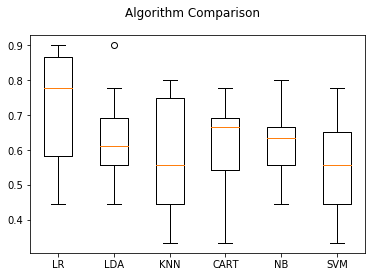

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.7144444444444444</span>

{'name': 'LR', 'score': 0.7144444444444444}
{'name': 'LDA', 'score': 0.6266666666666667}
{'name': 'KNN', 'score': 0.5822222222222223}
{'name': 'CART', 'score': 0.62}
{'name': 'NB', 'score': 0.6177777777777778}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 300021 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


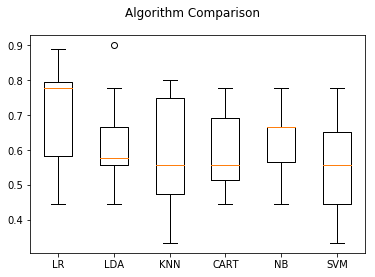

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.6933333333333334</span>

{'name': 'LR', 'score': 0.6933333333333334}
{'name': 'LDA', 'score': 0.6166666666666666}
{'name': 'KNN', 'score': 0.5822222222222222}
{'name': 'CART', 'score': 0.5977777777777777}
{'name': 'NB', 'score': 0.6211111111111112}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 249789 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


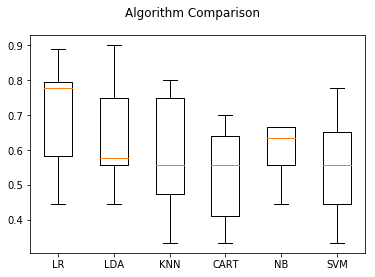

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.6933333333333334</span>

{'name': 'LR', 'score': 0.6933333333333334}
{'name': 'LDA', 'score': 0.6277777777777778}
{'name': 'KNN', 'score': 0.5933333333333334}
{'name': 'CART', 'score': 0.5211111111111111}
{'name': 'NB', 'score': 0.598888888888889}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 212518 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


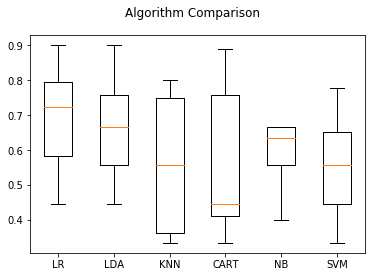

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.6922222222222223</span>

{'name': 'LR', 'score': 0.6922222222222223}
{'name': 'LDA', 'score': 0.6488888888888888}
{'name': 'KNN', 'score': 0.56}
{'name': 'CART', 'score': 0.5544444444444444}
{'name': 'NB', 'score': 0.5888888888888889}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 181350 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


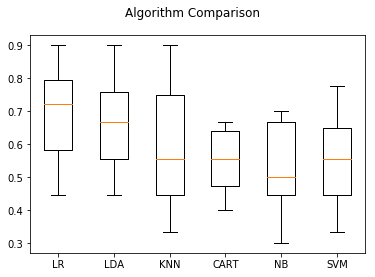

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.7033333333333334</span>

{'name': 'LR', 'score': 0.7033333333333334}
{'name': 'LDA', 'score': 0.6488888888888888}
{'name': 'KNN', 'score': 0.5811111111111111}
{'name': 'CART', 'score': 0.5466666666666666}
{'name': 'NB', 'score': 0.5333333333333334}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 153725 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


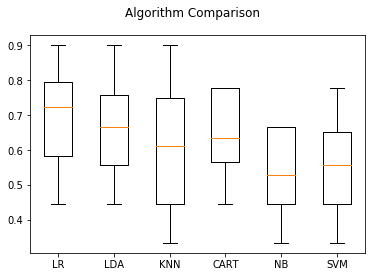

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.7033333333333334</span>

{'name': 'LR', 'score': 0.7033333333333334}
{'name': 'LDA', 'score': 0.6599999999999999}
{'name': 'KNN', 'score': 0.5922222222222222}
{'name': 'CART', 'score': 0.6533333333333333}
{'name': 'NB', 'score': 0.5344444444444444}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 129439 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


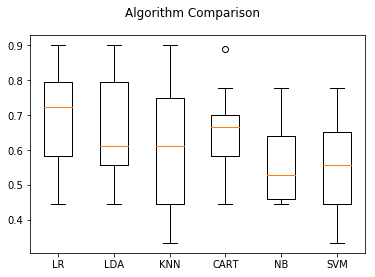

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.7033333333333334</span>

{'name': 'LR', 'score': 0.7033333333333334}
{'name': 'LDA', 'score': 0.6588888888888889}
{'name': 'KNN', 'score': 0.5922222222222222}
{'name': 'CART', 'score': 0.6622222222222222}
{'name': 'NB', 'score': 0.5555555555555556}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 108368 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


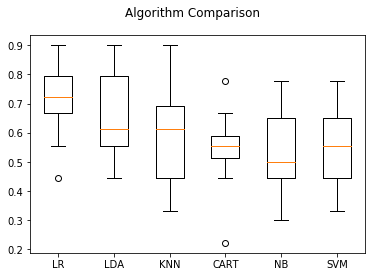

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.7144444444444445</span>

{'name': 'LR', 'score': 0.7144444444444445}
{'name': 'LDA', 'score': 0.6588888888888889}
{'name': 'KNN', 'score': 0.5822222222222223}
{'name': 'CART', 'score': 0.5433333333333333}
{'name': 'NB', 'score': 0.5344444444444445}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 90282 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [ ]:
#need to modify the test shape
    printmd("**Testing Section:**")
    test_results = test_the_data(X_train,Y_train,X_test,Y_test,models)
    best_ts = get_the_best(test_results)
    for model in test_results:
        print (model)


In [9]:
    # #after we found the elbow
    # new_shape = []
    # range = np.arange(0.04, 0.17, 0.001)
    # for VTHRESH in range:  
    #     sel = fs.VarianceThreshold(VTHRESH)
    #     x = sel.fit_transform(X_train)
    #     new_shape.append(x.shape[-1])
    # plt.plot(range, new_shape)